<a href="https://colab.research.google.com/github/JobranZaiter/.Net2023JobranZaiter/blob/main/DeepGlobe-Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import shutil
import os
import os
import cv2
from glob import glob

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.makedirs("dataset", exist_ok=True)
shutil.unpack_archive(r"drive/My Drive/Machine-Learning/Landcover-Semantic-Segmentation/archive.zip", "data")

In [ ]:
def save_patches(train_path, save_dir):
    train_dir = glob(train_path)
    print(len(train_dir))
    os.makedirs(save_dir, exist_ok=True)
    patch_size = 624
    stride = 608

    for i in range(len(train_dir)):
        sub_path = train_dir[i].split('/')[2].split('_')[1].split('.')[0]
        filename = train_dir[i].split('/')[2].split('_')[0]

        image = cv2.imread(train_dir[i])
        height, width = image.shape[:2]
        counter = 0

        output_subdir = os.path.join(save_dir, sub_path)
        os.makedirs(output_subdir, exist_ok=True)

        for y in range(0, height - patch_size + 1, stride):
            for x in range(0, width - patch_size + 1, stride):
                patch = image[y:y+patch_size, x:x+patch_size, :]
                save_path = os.path.join(output_subdir, f"{filename}_{counter}.png")
                cv2.imwrite(save_path, patch)
                counter += 1


In [ ]:
save_dir = "drive/My Drive/Machine-Learning/Landcover-Patches-Dataset/train"
save_patches("data/train/*", save_dir)

1606


In [ ]:
patches = "drive/My Drive/Machine-Learning/Landcover-Patches-Dataset/train/mask/*"
patches_dir = glob(patches)
len(patches_dir)

12848

In [ ]:
os.path.exists("drive/My Drive/Machine-Learning/Landcover-Dataset/train/images/100694_0.jpg")

True

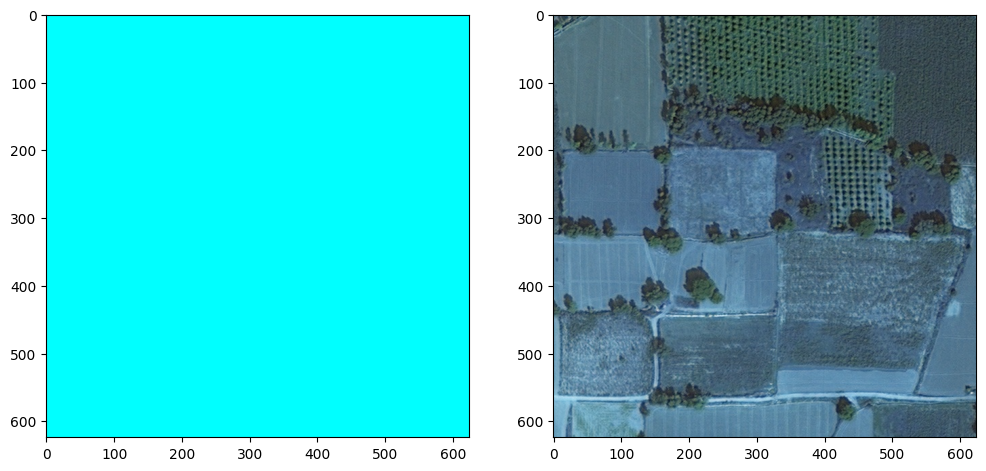

In [ ]:
mask_patch = "drive/My Drive/Machine-Learning/Landcover-Dataset/train"
def verify_patches(train_dir, image_code):
    mask_dir = os.path.join(train_dir, "masks", image_code)
    images_dir = os.path.join(train_dir, "images", image_code)
    mask = cv2.imread(mask_dir)
    image = cv2.imread(images_dir)

    fig, ax = plt.subplots(1,2, figsize=(12,8))
    ax[0].imshow(mask)
    ax[1].imshow(image)
    plt.show()

verify_patches(mask_patch, "100694_4.jpg")

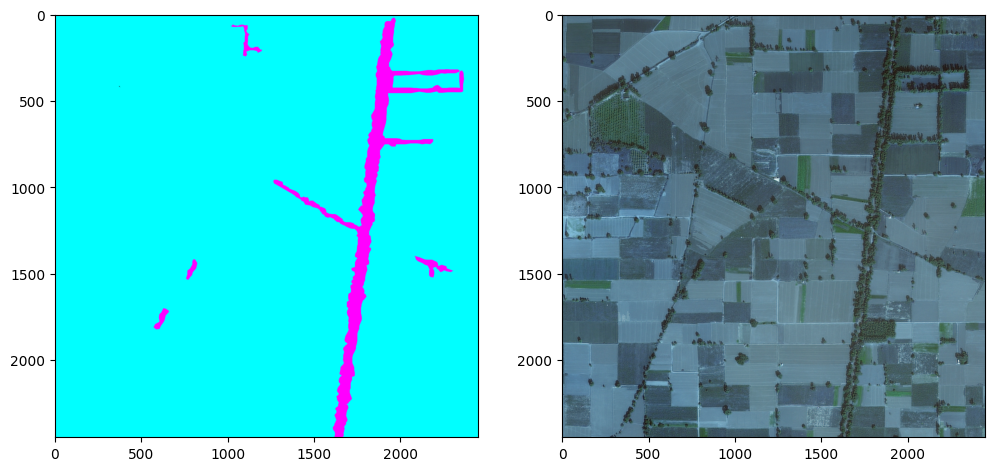

In [ ]:
image = cv2.imread("data/train/100694_sat.jpg")
mask = cv2.imread("data/train/100694_mask.png")
if mask is None:
    raise FileNotFoundError("Mask not found or unreadable: check path or file format.")
if image is None:
    raise FileNotFoundError("Image not found or unreadable: check path or file format.")
fig, ax = plt.subplots(1, 2, figsize=(12,8))
ax[0].imshow(mask)
ax[1].imshow(image)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
import shutil
image_dir= "drive/My Drive/Machine-Learning/Landcover-Patches-Dataset/train/sat"
all_image_paths = glob(os.path.join(image_dir, "*.png"))
imagenumbers = sorted(set([os.path.basename(f).split('_')[0] for f in all_image_paths]))
train_images, val_images = train_test_split(imagenumbers, test_size=0.1, random_state=42)

def move_images(images, src_dir, dest_dir):
  for image in images:
    for i in range(16):
      src_image = os.path.join(src_dir,"sat", f"{image}_{i}.png")
      src_mask = os.path.join(src_dir, "mask", f"{image}_{i}.png")

      dest_image = os.path.join(dest_dir,"images", f"{image}_{i}.png")
      dest_mask = os.path.join(dest_dir,"masks", f"{image}_{i}.png")
      shutil.move(src_image, dest_image)
      shutil.move(src_mask, dest_mask)

base_dir = "drive/My Drive/Machine-Learning/Landcover-Patches-Dataset/train"
save_dir = "drive/My Drive/Machine-Learning/Landcover-Dataset"
move_images(train_images, base_dir, os.path.join(save_dir, "train"))
move_images(val_images, base_dir, os.path.join(save_dir, "val"))

In [ ]:
print(len(glob("drive/My Drive/Machine-Learning/Landcover-Dataset/train/masks/*")))

11552


In [ ]:
print(len(glob("drive/My Drive/Machine-Learning/Landcover-Dataset/val/masks/*")))

1296


In [ ]:
print(len(glob("data/train/*")))

1606


In [ ]:
data_dir = "drive/My Drive/Machine-Learning/Landcover-Dataset/train"
image_dir = os.path.join(data_dir, "images")
image_files = os.listdir(image_dir)
image_files[0]

'437963_0.jpg'

In [ ]:
import pandas as pd
df = pd.read_csv("data/class_dict.csv")
df

,name,r,g,b
0,urban_land,0,255,255
1,agriculture_land,255,255,0
2,rangeland,255,0,255
3,forest_land,0,255,0
4,water,0,0,255
5,barren_land,255,255,255
6,unknown,0,0,0


In [ ]:
import numpy as np
color_dict = {
    (0, 255, 255): 0,
    (255, 255, 0): 1,
    (255, 0, 255): 2,
    (0, 255, 0): 3,
    (0, 0, 255): 4,
    (255, 255, 255): 5,
    (0, 0, 0): 6
}
def convert_masks(mask):
  h, w, c = mask.shape
  valid_mask = np.zeros((h, w), dtype=np.uint8)

  for rgb, idx in color_dict.items():
    matches = np.all(mask == np.array(rgb), axis=-1)
    valid_mask[matches] = idx
  one_hot = np.eye(7)[valid_mask]
  return one_hot.astype(np.int32).transpose(2, 0, 1).astype(np.float16)

In [ ]:
from torch.utils.data import Dataset
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

class DatasetLoader(Dataset):
  def __init__(self, data_dir, augmentations=True):

    self.mean = np.array([0.485, 0.456, 0.406])
    self.std = np.array([0.229, 0.224, 0.225])
    if augmentations:
      self.transform = A.Compose([
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3),
        A.RandomBrightnessContrast(p=0.2),
        A.Rotate(limit=20, p=0.2),
        A.MotionBlur(p=0.1),
        A.GaussNoise(var_limit=(5.0, 20.0), p=0.1),
        A.Normalize(mean=self.mean, std=self.std),
        ToTensorV2()
      ])
    self.shape = (624, 624, 3)
    self.image_dir = os.path.join(data_dir, "images")
    self.mask_dir = os.path.join(data_dir, "masks")

    self.image_files = sorted(os.listdir(self.image_dir))
    self.mask_files = sorted(os.listdir(self.mask_dir))

    if self.image_files != self.mask_files:
      raise ValueError("Image and mask names must be the same")
  def __len__(self):
      return len(self.image_files)

  def __getitem__(self, idx):
    image = cv2.imread(os.path.join(self.image_dir, self.image_files[idx]))
    mask = cv2.imread(os.path.join(self.mask_dir, self.mask_files[idx]))

    if image.shape != self.shape:
      raise ValueError(f"Image shape {image.shape} does not match expected shape {self.shape}")
    if mask.shape != self.shape:
      raise ValueError(f"Mask shape {mask.shape} does not match expected shape {self.shape}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    if self.transform:
      augmented = self.transform(image=image, mask=mask)
      image = augmented['image']
      mask = augmented['mask']
      mask = convert_masks(mask.numpy())
      mask = torch.from_numpy(mask).long()
    else:
      image = image.astype(np.float32) / 255.0
      image = (image - self.mean) / self.std
      image = image.transpose((2, 0, 1))
      image = torch.from_numpy(image).float()
      mask = torch.from_numpy(mask).long()

    return image, mask

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
class AttrousConvolution(nn.Module):
  def __init__(self, filter_size, in_channels, out_channels, pad, dilation):
    super(AttrousConvolution, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=filter_size, padding=pad, dilation=dilation, bias=False)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    x = self.relu(x)
    return x
class ASPP(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ASPP, self).__init__()
    self.conv_1x1 = AttrousConvolution(1,in_channels, out_channels, 0, 1)
    self.conv_3x3_6 = AttrousConvolution(3, in_channels, out_channels, 6, 6)
    self.conv_3x3_12 = AttrousConvolution(3, in_channels, out_channels, 12, 12)
    self.conv_3x3_18 = AttrousConvolution(3, in_channels, out_channels, 18, 18)
    self.pooling = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    self.final_conv = nn.Sequential(
        nn.Conv2d(out_channels*5, out_channels, kernel_size=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
      x1 = self.conv_1x1(x)
      x2 = self.conv_3x3_6(x)
      x3 = self.conv_3x3_12(x)
      x4 = self.conv_3x3_18(x)
      x5 = self.pooling(x)
      x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)

      concatenated_x = torch.cat([x1, x2, x3, x4, x5], dim=1)
      output = self.final_conv(concatenated_x)
      return output

class DeepLabV3(nn.Module):
  def __init__(self, num_classes, in_channels=3):
    super(DeepLabV3, self).__init__()
    self.backbone = models.resnet50(weights= models.ResNet50_Weights.IMAGENET1K_V1)
    self.conv_bn = nn.Sequential(
        self.backbone.conv1,
        self.backbone.bn1,
        self.backbone.relu,
        self.backbone.maxpool
    )

    self.layer1 = self.backbone.layer1
    self.layer2 = self.backbone.layer2
    self.layer3 = self.backbone.layer3
    self.layer4 = self.backbone.layer4

    self.aspp = ASPP(2048, 256)
    self.dim_reduce = AttrousConvolution(1, 256, 48,0,1)

    self.final_conv = AttrousConvolution(3, 304, 256, 1, 1)

    self.head = nn.Conv2d(256, num_classes, kernel_size=1)


  def forward(self, x):
    x_1 = self.conv_bn(x)
    x_2 = self.layer1(x_1)
    x_3 = self.layer2(x_2)
    x_4 = self.layer3(x_3)
    x_5 = self.layer4(x_4)

    x_aspp = self.aspp(x_5)
    xaspp_upsampled = F.interpolate(x_aspp, size=x_2.size()[2:], mode='bilinear', align_corners=True)
    x_low = self.dim_reduce(x_2)

    x_multiscale = torch.cat([x_low, xaspp_upsampled], dim=1)
    x_final = self.final_conv(x_multiscale)

    x_upsampled = F.interpolate(x_final, size=x.size()[2:], mode='bilinear', align_corners=True)
    prediction = self.head(x_upsampled)
    return prediction


In [ ]:
model = models.resnet50(pretrained=True)

for name, layer in model.named_children():
    print(f"{name}: {layer}")

conv1: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
bn1: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu: ReLU(inplace=True)
maxpool: MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer1: Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=

In [ ]:
class CustomLoss(nn.Module):

  def __init__(self, ce_weight=0.3, dice_weight=0.7, epsilon=1e-6):
    super().__init__()
    self.epsilon = epsilon
    self.ce_weight = ce_weight
    self.dice_weight = dice_weight
    self.ce = nn.CrossEntropyLoss()

  def dice_coeff(self, y_true, y_pred):
    y_pred = F.softmax(y_pred, dim=1)

    y_pred_flat = y_pred.contiguous().view(y_pred.shape[0], y_pred.shape[1], -1)
    y_true_flat = y_true.contiguous().view(y_true.shape[0], y_true.shape[1], -1)

    intersection = torch.sum(y_pred_flat * y_true_flat, dim=2)
    union = torch.sum(y_pred_flat, dim=2) + torch.sum(y_true_flat, dim=2)
    dice_score = (2.0 * intersection + self.epsilon) / (union + self.epsilon)

    return 1 - dice_score.mean()

  def forward(self, y_true, y_pred):
    ce_loss = self.ce(y_pred, y_true.argmax(axis=1))
    dice_loss = self.dice_coeff(y_true, y_pred)
    return self.ce_weight*ce_loss + self.dice_weight*dice_loss

In [ ]:
from torch.utils.data import DataLoader
train_dir = "drive/My Drive/Machine-Learning/Landcover-Dataset/train"
val_dir = "drive/My Drive/Machine-Learning/Landcover-Dataset/val"

train_dataset = DatasetLoader(train_dir)
val_dataset = DatasetLoader(val_dir)

train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=2,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=12, shuffle=False, num_workers=2,pin_memory=True)

<ipython-input-4-bc660dd4068c>:18: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=0.1),


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepLabV3(num_classes=7).to(device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]


In [ ]:
def IoU(y_true, y_pred, num_classes=7):
  true_idx = y_true.argmax(axis=1)
  pred_idx = y_pred.argmax(axis=1)

  pred_oh = F.one_hot(pred_idx, num_classes=num_classes).permute(0, 3, 1, 2)
  true_oh = F.one_hot(true_idx, num_classes=num_classes).permute(0, 3, 1, 2)
  intersection = torch.sum(pred_oh * true_oh, dim=(0, 2, 3))
  union = torch.sum(pred_oh, dim=(0, 2, 3)) + torch.sum(true_oh, dim=(0, 2, 3)) - intersection
  iou = intersection / (union + 1e-6)
  return iou.mean()



In [ ]:
import torch.optim as optim


checkpoint_path="drive/My Drive/Machine-Learning/DeepLabModel"
curr_checkpoint = "drive/My Drive/Machine-Learning/DeepLabModel/epoch_3.pth"
os.makedirs(checkpoint_path, exist_ok=True)
num_classes = 7
lr = 1e-4
batch_size = 4
curr_epoch = 3
num_epochs = 50

loss_fn = CustomLoss(ce_weight=0.3, dice_weight=0.7).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
ckpt = torch.load(curr_checkpoint, map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
optimizer.load_state_dict(ckpt["optim_state_dict"])

for epoch in range(curr_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    step = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).float()

        logits = model(images)
        loss = loss_fn(masks, logits)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cur_iou = IoU(masks, logits).item()
        cur_loss = loss.item()
        print(f"Current step:{step} / Current IoU: {cur_iou} / Cur Loss: {cur_loss}")
        running_iou += cur_iou * images.size(0)
        running_loss += cur_loss * images.size(0)
        step += 1
    epoch_iou = running_iou / len(train_loader.dataset)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"[Epoch {epoch+1}/{num_epochs}] Train loss: {epoch_loss} Mean IoU: {epoch_iou}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks  = masks.to(device).float()

            logits = model(images)
            loss   = loss_fn(masks, logits)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Val loss: {val_loss:.4f}\n")
    checkpoint = os.path.join(checkpoint_path, f"epoch_{epoch+1}.pth")
    torch.save({"epoch":epoch,'model_state_dict': model.state_dict(),'optim_state_dict': optimizer.state_dict(),
                "train_loss":epoch_loss, "validation_loss":val_loss}, checkpoint)
    torch.cuda.empty_cache()


Current step:0 / Current IoU: 0.6030060052871704 / Cur Loss: 0.6801892518997192
Current step:1 / Current IoU: 0.4834102690219879 / Cur Loss: 0.65936678647995
Current step:2 / Current IoU: 0.7167421579360962 / Cur Loss: 0.6912091374397278
Current step:3 / Current IoU: 0.6096617579460144 / Cur Loss: 0.7754316329956055
Current step:4 / Current IoU: 0.5841687321662903 / Cur Loss: 0.6309634447097778
Current step:5 / Current IoU: 0.46979859471321106 / Cur Loss: 0.6515100002288818
Current step:6 / Current IoU: 0.5900990962982178 / Cur Loss: 0.677780270576477
Current step:7 / Current IoU: 0.5406293272972107 / Cur Loss: 0.7423276901245117
Current step:8 / Current IoU: 0.6765663623809814 / Cur Loss: 0.7250412702560425
Current step:9 / Current IoU: 0.5706411004066467 / Cur Loss: 0.7340097427368164
Current step:10 / Current IoU: 0.6793467998504639 / Cur Loss: 0.6543887853622437
Current step:11 / Current IoU: 0.5376729965209961 / Cur Loss: 0.6463968753814697
Current step:12 / Current IoU: 0.6412847

KeyboardInterrupt: 